In [24]:
import numpy as np
import matplotlib.pylab as plt
import corner
import numpy as np
import glob
from PTMCMCSampler import PTMCMCSampler

%matplotlib inline

## Define the likelihood and posterior

Functions must read in parameter vector and output log-likelihood or log-prior. Usually easiest to use a class if you need to store some other data or parameters

In [25]:
class GaussianLikelihood(object):
    
    def __init__(self, ndim=2, pmin=-10, pmax=10):
        
        self.a = np.ones(ndim)*pmin
        self.b = np.ones(ndim)*pmax
        
        # get means
        self.mu = np.random.uniform(pmin, pmax, ndim)

        # ... and a positive definite, non-trivial covariance matrix.
        cov  = 0.5-np.random.rand(ndim**2).reshape((ndim, ndim))
        cov  = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        self.cov  = np.dot(cov,cov)

        # Invert the covariance matrix first.
        self.icov = np.linalg.inv(self.cov)
        
    def lnlikefn(self, x):
        diff = x - self.mu
        return -np.dot(diff,np.dot(self.icov, diff))/2.0
    
    def lnpriorfn(self, x):
        
        if np.all(self.a <= x) and np.all(self.b >= x):
            return 0.0
        else:
            return -np.inf      


## Setup Gaussian model class

In [26]:
ndim = 2
pmin, pmax = 0.0, 10.0
glo = GaussianLikelihood(ndim=ndim, pmin=5., pmax=6.)

## Setup sampler

Need to initalize the sample at ```p0``` and give an inital jump covariance matrix ```cov```.

In [27]:
# Set the start position and the covariance
p0 = np.random.uniform(pmin, pmax, ndim)
cov = np.eye(ndim) * 0.1**2

In [28]:
sampler = PTMCMCSampler.PTSampler(ndim, glo.lnlikefn, glo.lnpriorfn, np.copy(cov), outDir='./chains')

## Jump Proposals

We have the option to choose whatever jump proposals we would like to use in our analysis. Here, we will use the `Uniform` jump proposal (meaning all jumps are equally likely).

In [29]:
weights = {"Uniform": 1}

jump_proposal_arguments = {"Uniform": {"pmin": 0, "pmax": 10}}

## Run Sampler for 100000 steps

Different jump proposal weights are given as integers. For example we have used a weight of 20 for all three proposals here. That means that each will be used with a probability of 20/60 = 1/3.

In [30]:
sampler.sample(p0, 100000, weights=weights, jump_proposal_arguments=jump_proposal_arguments,
               burn=500, thin=1, covUpdate=500)

Finished 99.00 percent in 15.555759 s Acceptance rate = 0.00656566
Run Complete


array([[5.8279725 , 5.49426533],
       [5.8279725 , 5.49426533],
       [5.8279725 , 5.49426533],
       ...,
       [5.28684936, 5.53175194],
       [5.28684936, 5.53175194],
       [5.28684936, 5.53175194]])

## Get jump statistics

Here you can track the acceptance rate of the different jump proposals used

(0.0, 1.1)

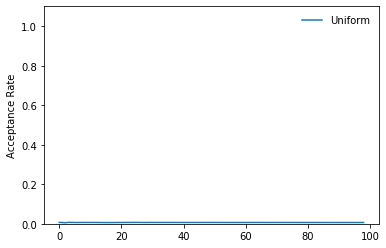

In [31]:
jumpfiles = glob.glob('chains/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')
plt.ylim(0.0, 1.1)

## Get the data and plot the output

The output data has ndim + 4 columns. The first ndim columns are just the samples from the parameters, the ndim+1 column is the log-posterior, ndim+2 is the log-likelihood, ndim+3 is the acceptance rate, and ndim+4 is the parallel tempering swap acceptance rate for the T=1 chain.

In [32]:
data = np.loadtxt('chains/chain_1.txt')
chaint = data[:,:-4]

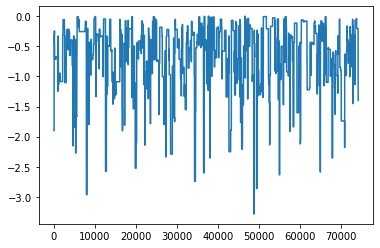

In [33]:
# throw out first 25% of chain as burn in 
burn = int(0.25*chaint.shape[0])
plt.plot(data[burn:,-4])

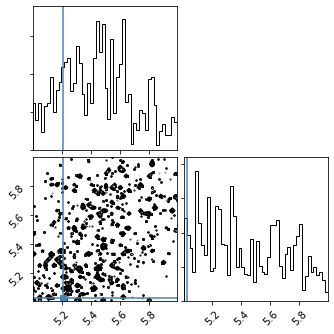

In [34]:
# get the true values and plot the posteriors for the first 10 parameters
truth = glo.mu
corner.corner(chaint[burn:,:10], bins=50, truths=truth);